## Import

In [1]:
# importing the libraries
import pandas as pd
import numpy as np
import os
import seaborn as sns
from itertools import chain

# for reading and displaying images
# from skimage.io import imread
import matplotlib.pyplot as plt
from glob import glob

# for creating validation set
from sklearn.model_selection import train_test_split

# PyTorch libraries and modules
import torch
import torch.nn as nn
import torch.nn.functional as F

# models
from src.architectures.resnet import *
from src.architectures.levakov_96 import *
from src.architectures.inception import *
from src.architectures.dinsdale import *

# other files
from src.run import *

# Torch
from torch.optim import *
import torch.optim as optim
from torchsummary import summary
from tensorboardX import SummaryWriter

# CAM - M3dCam
from medcam import medcam

## Dataloader
for kFold, it will be run again on the run

In [2]:
from src.dataloader import *

train_dset = MyDataset(task_type='age')
test_dset = MyDataset(task_type='age', test=True)

train_loader = DataLoader(train_dset, batch_size=8)
test_loader = DataLoader(test_dset, batch_size=8)

## Load Model

In [3]:
def load_model(model, verbose=True):
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f'Model {model.capitalize()} is selected.')

    if model == 'resnet':
        

        opt = Option()
        model = generate_model(model_depth=opt.model_depth,
                                    n_classes=opt.n_classes,
                                    n_input_channels=opt.n_input_channels,
                                    shortcut_type=opt.shortcut_type,
                                    conv1_t_size=opt.conv1_t_size,
                                    conv1_t_stride=opt.conv1_t_stride,
                                    no_max_pool=opt.no_max_pool,
                                    widen_factor=opt.resnet_widen_factor)

    elif model == 'levakov':
        model = Levakov(task_type='age')

    elif model == 'inception':
        model = Inception3()

    elif model == 'dinsdale':
        model = Dinsdale(1, 1, 2)

    else: return None

    model.to(device)
    if verbose:
        print(summary(model, input_size=(1, 96, 96, 96)))
    
    return model, device

model = 'resnet'
model, device = load_model(model)
# model = medcam.inject(model, output_dir="attention_maps", save_maps=True)

Model Resnet is selected.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 16, 96, 48, 48]           2,352
       BatchNorm3d-2       [-1, 16, 96, 48, 48]              32
              ReLU-3       [-1, 16, 96, 48, 48]               0
         MaxPool3d-4       [-1, 16, 48, 24, 24]               0
            Conv3d-5       [-1, 16, 48, 24, 24]           6,912
       BatchNorm3d-6       [-1, 16, 48, 24, 24]              32
              ReLU-7       [-1, 16, 48, 24, 24]               0
            Conv3d-8       [-1, 16, 48, 24, 24]           6,912
       BatchNorm3d-9       [-1, 16, 48, 24, 24]              32
             ReLU-10       [-1, 16, 48, 24, 24]               0
       BasicBlock-11       [-1, 16, 48, 24, 24]               0
           Conv3d-12       [-1, 32, 24, 12, 12]          13,824
      BatchNorm3d-13       [-1, 32, 24, 12, 12]              64
             

## Setups

Default Settings

In [4]:
task_type = 'age' # no longer used.
resize = True
scheduler = False
epochs = range(50)
folds = range(10)

Loss & Optimizer

In [5]:
from src.losses import RMSELoss

loss_fn = nn.MSELoss()
lamb = 0.0005
# optimizer = optim.Adam(model.parameters(), lr=1e-4)

Metrics

In [6]:
rmse_fn = RMSELoss()
mae_fn = nn.L1Loss()

## Run

### without Folds

Model Resnet is selected.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 16, 96, 48, 48]           2,352
       BatchNorm3d-2       [-1, 16, 96, 48, 48]              32
              ReLU-3       [-1, 16, 96, 48, 48]               0
         MaxPool3d-4       [-1, 16, 48, 24, 24]               0
            Conv3d-5       [-1, 16, 48, 24, 24]           6,912
       BatchNorm3d-6       [-1, 16, 48, 24, 24]              32
              ReLU-7       [-1, 16, 48, 24, 24]               0
            Conv3d-8       [-1, 16, 48, 24, 24]           6,912
       BatchNorm3d-9       [-1, 16, 48, 24, 24]              32
             ReLU-10       [-1, 16, 48, 24, 24]               0
       BasicBlock-11       [-1, 16, 48, 24, 24]               0
           Conv3d-12       [-1, 32, 24, 12, 12]          13,824
      BatchNorm3d-13       [-1, 32, 24, 12, 12]              64
             

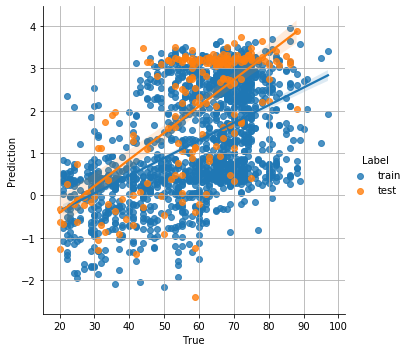

MSE  :: [TRAIN] 3569.440 | [VALID] 3380.577
RMSE :: [TRAIN] 59.629  | [VALID] 58.109
CORR :: [TRAIN] 0.528 | [VALID] 0.657

WorkingTime[train]: 73.71823716163635 sec
WorkingTime[train]: 107.12901449203491 sec
WorkingTime[eval]: 17.090986490249634 sec
WorkingTime[make_df]: 0.002992391586303711 sec
WorkingTime[make_df]: 0.002992391586303711 sec
WorkingTime[make_df]: 0.0019941329956054688 sec
FOLD None - EPOCHS 1
MAE  :: [TRAIN] 56.312   | [TEST] 54.950
WorkingTime[train]: 72.79610681533813 sec
WorkingTime[train]: 105.62607192993164 sec
WorkingTime[eval]: 16.56196618080139 sec
WorkingTime[make_df]: 0.0009987354278564453 sec
WorkingTime[make_df]: 0.0019948482513427734 sec
WorkingTime[make_df]: 0.0 sec
FOLD None - EPOCHS 2
MAE  :: [TRAIN] 55.422   | [TEST] 52.883
WorkingTime[train]: 72.09914302825928 sec
WorkingTime[train]: 104.4258713722229 sec
WorkingTime[eval]: 16.063557386398315 sec
WorkingTime[make_df]: 0.0009968280792236328 sec
WorkingTime[make_df]: 0.0029921531677246094 sec
WorkingTi

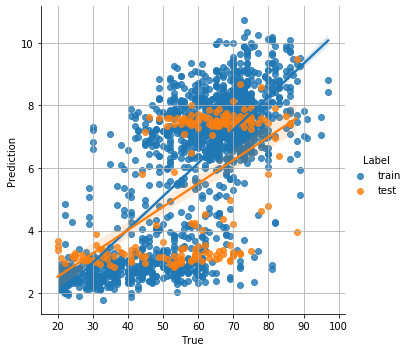

MSE  :: [TRAIN] 2996.016 | [VALID] 3007.416
RMSE :: [TRAIN] 54.606  | [VALID] 54.813
CORR :: [TRAIN] 0.736 | [VALID] 0.544

WorkingTime[train]: 73.69854187965393 sec
WorkingTime[train]: 107.49027919769287 sec
WorkingTime[eval]: 16.40847611427307 sec
WorkingTime[make_df]: 0.002992391586303711 sec
WorkingTime[make_df]: 0.0029914379119873047 sec
WorkingTime[make_df]: 0.0019960403442382812 sec
FOLD None - EPOCHS 6
MAE  :: [TRAIN] 51.695   | [TEST] 52.072
WorkingTime[train]: 80.37683987617493 sec
WorkingTime[train]: 117.62113976478577 sec
WorkingTime[eval]: 17.270737648010254 sec
WorkingTime[make_df]: 0.003987312316894531 sec
WorkingTime[make_df]: 0.003989458084106445 sec
WorkingTime[make_df]: 0.0019941329956054688 sec
FOLD None - EPOCHS 7
MAE  :: [TRAIN] 50.652   | [TEST] 50.991
WorkingTime[train]: 73.48398566246033 sec
WorkingTime[train]: 111.41071033477783 sec
WorkingTime[eval]: 16.76914119720459 sec
WorkingTime[make_df]: 0.002992391586303711 sec
WorkingTime[make_df]: 0.00299239158630371

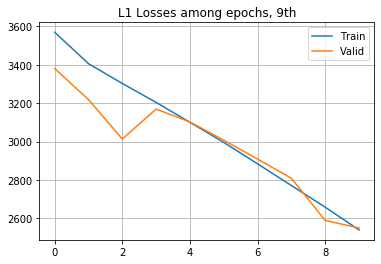

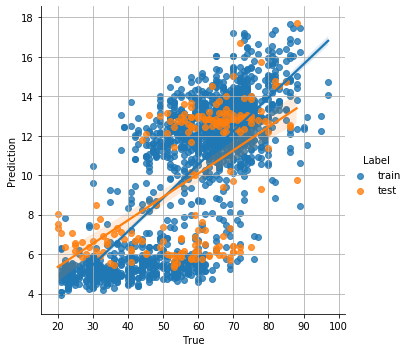

WorkingTime[train]: 72.29879760742188 sec
WorkingTime[train]: 114.2577474117279 sec


In [ ]:
model_name = 'resnet'
model, device = load_model(model_name)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

trn_losses, trn_maes, trn_rmses = [], [], []
aug_losses, aug_maes, aug_rmses = [], [], []
tst_losses, tst_maes, tst_rmses = [], [], []

fold = None
batch_size = 16
for e in epochs:
        
    model, (trn_losses, trn_maes, trn_rmses), trn_preds = train(model, False, None, fold, resize, device, batch_size,
                                                                loss_fn, mae_fn, rmse_fn,
                                                                trn_losses, trn_maes, trn_rmses,
                                                                optimizer, scheduler, lamb)

    model, (aug_losses, aug_maes, aug_rmses), aug_preds = train(model, False, True, fold, resize, device, batch_size,
                                                                loss_fn, mae_fn, rmse_fn,
                                                                aug_losses, aug_maes, aug_rmses,
                                                                optimizer, scheduler, lamb)
        
    model, (tst_losses, tst_maes, tst_rmses), tst_preds = eval(model, True, None, fold, resize, device, batch_size,
                                                           loss_fn, mae_fn, rmse_fn,
                                                           tst_losses, tst_maes, tst_rmses)

    # SUM UP RESLUTS
    trn_df = make_df(trn_preds, 'train')
    aug_df = make_df(aug_preds, 'train')
    tst_df = make_df(tst_preds, 'test')
    reg_df = pd.concat([trn_df, tst_df, aug_df], ignore_index=True)

    trn_corr = reg_df[reg_df['Label'] == 'train'].corr().Prediction['True']
    tst_corr = reg_df[reg_df['Label'] == 'test'].corr().Prediction['True']

    print(f'FOLD {fold} - EPOCHS {e}')
    print(f'MAE  :: [TRAIN] {trn_maes[-1]:.3f}   | [TEST] {tst_maes[-1]:.3f}')
    
    if e % 5 == 0:
        
        sns_plot = sns.lmplot(data=reg_df, x='True', y='Prediction', hue='Label')
        sns_plot.savefig(f'{fold}.png')
        plt.grid()
        plt.show()
        
        print(f'MSE  :: [TRAIN] {trn_losses[-1]:.3f} | [VALID] {tst_losses[-1]:.3f}')
        print(f'RMSE :: [TRAIN] {trn_rmses[-1]:.3f}  | [VALID] {tst_rmses[-1]:.3f}')
        print(f'CORR :: [TRAIN] {trn_corr:.3f} | [VALID] {tst_corr:.3f}\n')

    if e % 10 == 9:
        plt.title(f"L1 Losses among epochs, {e}th")
        plt.plot(trn_losses, label='Train')
        plt.plot(tst_losses, label='Valid')
        plt.grid()
        plt.legend()

        sns.lmplot(data=reg_df, x='True', y='Prediction', hue='Label')
        plt.grid()
        plt.show()

torch.save(model, f'./models/{model_name}_{e}_{tst_maes[-1]}_0106.pth')

del model
torch.cuda.empty_cache()

## Inference


In [ ]:
model = medcam.inject(model, output_dir="attention_maps", save_maps=True, retain_graph=True, layer='layer1')
model, (tst_losses, tst_maes, tst_rmses), tst_preds = eval(model, True, None, fold, resize, device, batch_size,
                                                       loss_fn, mae_fn, rmse_fn,
                                                       tst_losses, tst_maes, tst_rmses)

### kFold Run

In [ ]:
best_loss = 10

trn_fold_losses, tst_fold_losses = [], []
trn_fold_corrs, tst_fold_corrs = [], []

trn_fold = {
    'MSE': list(),
    'MAE': list(),
    'RMSE': list(),
    'Correlation': list()
}

val_fold = {
    'MSE': list(),
    'MAE': list(),
    'RMSE': list(),
    'Correlation': list()
}

tst_losses, tst_maes, tst_rmses = [], [], []
for fold in folds:
    
    model_name = 'resnet'
    model, device = load_model(model_name)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    
    trn_losses, val_losses = [], []
    trn_maes, val_maes = [], []
    trn_rmses, val_rmses = [], []
    
    aug_losses, aug_maes, aug_rmses = [], [], []
    
    for e in epochs:

        model, (trn_losses, trn_maes, trn_rmses), trn_preds = train(model, False, None, fold, resize, device,
                                                              loss_fn, mae_fn, rmse_fn,
                                                              trn_losses, trn_maes, trn_rmses,
                                                              optimizer, scheduler, lamb)
        
        model, (aug_losses, aug_maes, aug_rmses), aug_preds = train(model, False, True, fold, resize, device,
                                                              loss_fn, mae_fn, rmse_fn,
                                                              aug_losses, aug_maes, aug_rmses,
                                                              optimizer, scheduler, lamb)
        
        model, (val_losses, val_maes, val_rmses), val_preds =  eval(model, True, None, fold, resize, device,
                                                              loss_fn, mae_fn, rmse_fn,
                                                              val_losses, val_maes, val_rmses)


        # SUM UP RESLUTS
        trn_df = make_df(trn_preds, 'train')
        val_df = make_df(val_preds, 'valid')
        aug_df = make_df(aug_preds, 'train')
        reg_df = pd.concat([trn_df, val_df, aug_df], ignore_index=True)

        trn_corr = reg_df[reg_df['Label'] == 'train'].corr().Prediction['True']
        val_corr = reg_df[reg_df['Label'] == 'valid'].corr().Prediction['True']

        
        print(f'FOLD {fold} - EPOCHS {e}')
        print(f'MAE  :: [TRAIN] {trn_maes[-1]:.3f}   | [VALID] {val_maes[-1]:.3f}')
        if e % 5 == 0:
            print(f'MSE  :: [TRAIN] {trn_losses[-1]:.3f} | [VALID] {val_losses[-1]:.3f}')
            print(f'RMSE :: [TRAIN] {trn_rmses[-1]:.3f}  | [VALID] {val_rmses[-1]:.3f}')
            print(f'CORR :: [TRAIN] {trn_corr:.3f} | [VALID] {val_corr:.3f}\n')

        if e % 10 == 9:
            plt.title(f"L1 Losses among epochs, {e}th")
            plt.plot(trn_losses, label='Train')
            plt.plot(val_losses, label='Valid')
            plt.grid(); plt.legend()
            
            sns.lmplot(data=reg_df, x='True', y='Prediction', hue='Label')
            plt.grid()
            plt.show()
    
    torch.save(model, f'./models/{model_name}_1222_{fold}_{e}_{trn_losses[-1]}.pth')
    
    trn_fold['MSE'].append(trn_losses)
    trn_fold['MAE'].append(trn_maes)
    trn_fold['RMSE'].append(trn_rmses)
    trn_fold['Correlation'].append(trn_corr)
    
    val_fold['MSE'].append(val_losses)
    val_fold['MAE'].append(val_maes)
    val_fold['RMSE'].append(val_rmses)
    val_fold['Correlation'].append(val_corr)
    
    # TEST
    test_dset = MyDataset(task_type='age', test=True)
    test_loader = DataLoader(test_dset, batch_size=8)
    
    model, (tst_losses, tst_maes, tst_rmses), tst_preds = eval(model, test_loader, resize, device,
                                                              loss_fn, mae_fn, rmse_fn,
                                                              tst_losses, tst_maes, tst_rmses)

    tst_df = make_df(tst_preds, 'test')
    reg_df = pd.concat([reg_df, tst_df], ignore_index=True)

    tst_corr = reg_df[reg_df['Label'] == 'test'].corr().Prediction['True']
    
    print(f'FOLD {fold}', end='')
    print(f'MSE  :: [TEST] {tst_losses[-1]:.3f}')
    print(f'MAE  :: [TEST] {tst_maes[-1]:.3f}')
    print(f'RMSE :: [TEST] {tst_rmses[-1]:.3f}')
    print(f'CORR :: [TEST] {tst_corr:.3f}')
    
    torch.save(model, f'./models/{model_name}_{tst_maes[-1]}.pth')

    sns_plot = sns.lmplot(data=reg_df, x='True', y='Prediction', hue='Label')
    sns_plot.savefig(f'{fold}.png')
    plt.grid()
    plt.show()
    
    del model
    torch.cuda.empty_cache()

In [ ]:
# torch.save(model, 'model.pth')

In [ ]:
# best_loss = 10

# trn_fold_losses, tst_fold_losses = [], []
# trn_fold_corrs, tst_fold_corrs = [], []

# trn_fold = {
#     'MSE': list(),
#     'MAE': list(),
#     'RMSE': list(),
#     'Correlation': list()
# }

# tst_fold = {
#     'MSE': list(),
#     'MAE': list(),
#     'RMSE': list(),
#     'Correlation': list()
# }

# for fold in folds:
    
#     train_dset = MyDataset(task_type='age', fold=fold)
#     test_dset = MyDataset(task_type='age', test=True, fold=fold)

#     train_loader = DataLoader(train_dset, batch_size=8)
#     test_loader = DataLoader(test_dset, batch_size=8)
    
#     trn_losses, tst_losses = [], []
#     trn_maes, tst_maes = [], []
#     trn_rmses, tst_rmses = [], []
#     for e in epochs:

#         # TRAIN
#         trn_bth_loss, trn_bth_mae, trn_bth_rmse = 0, 0, 0
#         trn_trues, trn_preds = [], []
#         model.train()
#         for i, (x, y) in enumerate(train_loader):

#             if resize:
#                 x, y = F.interpolate(x, size=(96, 96, 96)).to(device), y.to(device)

#             else:
#                 x, y = x.to(device), y.to(device)

#             optimizer.zero_grad()

#             y_pred = model.forward(x).to(device)

#             trn_trues.append(y.to('cpu'))
#             trn_preds.append(y_pred.to('cpu'))

#             # Loss
#             loss = loss_fn(y_pred.squeeze(1), y)
            
#             # Metrics
#             mae = mae_fn(y_pred.squeeze(1), y)
#             rmse = rmse_fn(y_pred.squeeze(1), y)
            
#             del x, y, y_pred

#             loss.backward()
#             optimizer.step()
#             if scheduler: scheduler.step()

#             trn_bth_loss += loss.item()
#             trn_bth_mae  += loss.item()
#             trn_bth_rmse += loss.item()

#         torch.cuda.empty_cache()

#         ### loss
#         trn_losses.append(trn_bth_loss / len(train_loader))
#         trn_maes.append(trn_bth_mae / len(train_loader))
#         trn_rmses.append(trn_bth_rmse / len(train_loader))

#         ### collect trues/predictions
#         trn_trues = list(chain(*trn_trues))
#         trn_preds = list(chain(*trn_preds))

        
#         # VALID
#         tst_bth_loss, tst_bth_mae, tst_bth_rmse = 0, 0, 0
#         model.eval()
#         tst_trues, tst_preds = [], []
#         with torch.no_grad(): # to not give loads on GPU... :(
#             for i, (x, y) in enumerate(test_loader):
#                 if resize:
#                     x, y = F.interpolate(x, size=(96, 96, 96)).to(device), y.to(device)

#                 else:
#                     x, y = x.to(device), y.to(device)

#                 y_pred = model.forward(x).to(device)

#                 tst_trues.append(y.to('cpu'))
#                 tst_preds.append(y_pred.to('cpu'))

#                 # Loss
#                 loss = loss_fn(y_pred.squeeze(1), y)
                
#                 # Metrics
#                 mae = mae_fn(y_pred.squeeze(1), y)
#                 rmse = rmse_fn(y_pred.squeeze(1), y)
                
#                 del x, y, y_pred

#                 tst_bth_loss += loss.item()
#                 tst_bth_mae  += loss.item()
#                 tst_bth_rmse += loss.item()
                
#         torch.cuda.empty_cache()
        
#         ### loss
#         tst_losses.append(tst_bth_loss / len(test_loader))
#         tst_maes.append(tst_bth_mae / len(test_loader))
#         tst_rmses.append(tst_bth_rmse / len(test_loader))

#         ### collect trues/predictions
#         tst_trues = list(chain(*tst_trues))
#         tst_preds = list(chain(*tst_preds))

        
#         # SUM UP RESLUTS
#         reg_df = pd.DataFrame({
#             'True': list(map(float, trn_trues + tst_trues)),
#             'Prediction': list(map(float, trn_preds + tst_preds)),
#             'Label': ['train'] * len(trn_trues) + ['valid'] * len(tst_trues)
#         })

#         trn_corr = reg_df[reg_df['Label'] == 'train'].corr().Prediction['True']
#         tst_corr = reg_df[reg_df['Label'] == 'valid'].corr().Prediction['True']

#         if e % 5 == 0:
#             print(f'FOLD {fold} - EPOCHS {e}')
#             print(f'MSE  :: [TRAIN] {trn_losses[-1]:.3f} | [VALID] {tst_losses[-1]:.3f}')
#             print(f'MAE  :: [TRAIN] {trn_maes[-1]:.3f}   | [VALID] {tst_maes[-1]:.3f}')
#             print(f'RMSE :: [TRAIN] {trn_rmses[-1]:.3f}  | [VALID] {tst_rmses[-1]:.3f}')
#             print(f'CORR :: [TRAIN] {trn_corr:.3f} | [VALID] {tst_corr:.3f}')

#         if e % 10 == 9:
#             plt.title(f"L1 Losses among epochs, {e}th")
#             plt.plot(trn_losses, label='Train')
#             plt.plot(tst_losses, label='Valid')
#             plt.grid(); plt.legend()
            
#             sns.lmplot(data=reg_df, x='True', y='Prediction', hue='Label')
#             plt.grid()
#             plt.show()
    
#     trn_fold['MSE'].append(trn_losses)
#     trn_fold['MAE'].append(trn_maes)
#     trn_fold['RMSE'].append(trn_rmses)
#     trn_fold['Correlation'].append(trn_corr)
    
#     tst_fold['MSE'].append(tst_losses)
#     tst_fold['MAE'].append(tst_maes)
#     tst_fold['RMSE'].append(tst_rmses)
#     tst_fold['Correlation'].append(tst_corr)
    
#     # TEST
#     test_dset = MyDataset(task_type='age', test=True)
#     test_loader = DataLoader(test_dset, batch_size=8)
    
#     tst_bth_loss = 0
#     model.eval()
#     tst_trues, tst_preds = [], []
#     with torch.no_grad(): # to not give loads on GPU... :(
#         for i, (x, y) in enumerate(test_loader):
#             if resize:
#                 x, y = F.interpolate(x, size=(96, 96, 96)).to(device), y.to(device)

#             else:
#                 x, y = x.to(device), y.to(device)

#             y_pred = model.forward(x).to(device)

#             tst_trues.append(y.to('cpu'))
#             tst_preds.append(y_pred.to('cpu'))

#             loss = loss_fn(y_pred.squeeze(1), y)
            
#             mae = mae_fn(y_pred.squeeze(1), y)
#             rmse = rmse_fn(y_pred.squeeze(1), y)
#             del x, y, y_pred

#             tst_bth_loss += loss.item()

#     torch.cuda.empty_cache()
#     ### loss
#     tst_loss = tst_bth_loss / len(test_loader)

#     ### collect trues/predictions
#     tst_trues = list(chain(*tst_trues))
#     tst_preds = list(chain(*tst_preds))
    
#     tst_df = pd.DataFrame({
#         'True': list(map(float, tst_trues)),
#         'Prediction': list(map(float, tst_preds)),
#         'Label': ['test'] * len(tst_trues)
#     })
#     reg_df = pd.concat([reg_df, tst_df], ignore_index=True)

#     tst_corr = reg_df[reg_df['Label'] == 'test'].corr().Prediction['True']
#     print(f'FOLD {fold}', end='')
#     print(f'RMSE :: [TEST] {tst_loss:.3f}')
#     print(f'CORR :: [TEST] {tst_corr:.3f}')

#     sns.lmplot(data=reg_df, x='True', y='Prediction', hue='Label')
#     plt.grid()
#     plt.show()